In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# parser v1
# parse records to list of dicts
# values mostly are strings
# easy to iterate through records
records = []
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        record = {}
        record['timestamp'] = int(components[0])
        record['displayed'] = components[1]
        record['clicked'] = int(components[2])
        # not using user feature
        record['user_features'] = []
        for i in range(4, len(components)):
            if components[i].startswith('|'):
                n = i
                break
            #record['user_features'].append(int(components[i]))
        record['pool'] = components[n:]    
        records.append(record)

In [175]:
records[i]['pool']

['|id-552077',
 '|id-555224',
 '|id-555528',
 '|id-559744',
 '|id-559855',
 '|id-560290',
 '|id-560518',
 '|id-560620',
 '|id-563115',
 '|id-563582',
 '|id-563643',
 '|id-563787',
 '|id-563846',
 '|id-563938',
 '|id-564335',
 '|id-564418',
 '|id-564604',
 '|id-565364',
 '|id-565479',
 '|id-565515',
 '|id-565533',
 '|id-565561',
 '|id-565589',
 '|id-565648',
 '|id-565747',
 '|id-565822']

In [3]:
len(records)

1607525

In [99]:
# parser that watches article lifespans
lives = {}
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        for component in components:
            if component.startswith('|id-'):
                timestamp = int(components[0])
                article = component[1:]
                if article in lives.keys():
                    lives[article][1] = timestamp
                else:
                    lives[article] = [timestamp, timestamp]

In [100]:
lives.keys()

dict_keys(['id-552077', 'id-555224', 'id-555528', 'id-559744', 'id-559855', 'id-560290', 'id-560518', 'id-560620', 'id-563115', 'id-563582', 'id-563643', 'id-563787', 'id-563846', 'id-563938', 'id-564335', 'id-564418', 'id-564604', 'id-565364', 'id-565479', 'id-565515', 'id-565533', 'id-565561', 'id-565589', 'id-565648', 'id-565747', 'id-565822', 'id-565930', 'id-566013', 'id-566022', 'id-566092', 'id-560805', 'id-564371', 'id-562265', 'id-565980', 'id-566431', 'id-566439', 'id-559833', 'id-566541', 'id-562374', 'id-566587', 'id-566478', 'id-566573', 'id-566602', 'id-562637', 'id-566631', 'id-566689', 'id-566726', 'id-566825', 'id-566838'])

In [246]:
# average lifespan
sum(map(lambda x:x[1]-x[0], lives.values())) / len(lives)

40648.4693877551

In [125]:
life_length = []
alive = []
for v in lives.values():
    alive.append(np.arange(v[0], v[1]+1))
    life_length.append(v[1]-v[0])

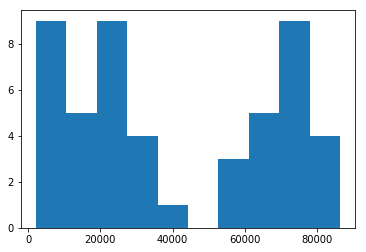

In [122]:
plt.hist(life_length)
pass

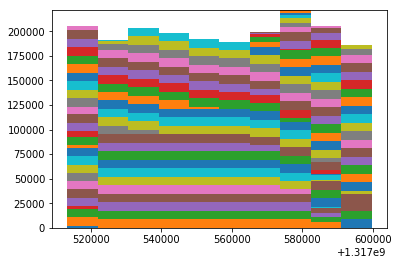

In [128]:
# number of arms available through out the timestamp
plt.hist(alive, histtype='barstacked')
pass

In [30]:
# offline simulation for AG_L
# slow but more accurate version
# comsumes much more records
def AG_L2(n=1000000,k=1, m=25, life_threshold=.3,verbose=True):
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    global records
    global lives # dict of articles to their lifespans
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked']
        if displayed not in X.keys():
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    n_exploit = 0
    n_explore = 0
    while t<=n:
        best = max(X.items(), key= lambda x:x[1][0]/x[1][1])
        X_max = best[1][0]/best[1][1]
        if np.random.binomial(1, min(1, X_max*k)): # exploit
            print(X_max)
            n_exploit += 1
            while records[i]['displayed'] != best[0]:
                i += 1
                if i >= len(records):
                    print('read out all records')
                    break
            rewards += records[i]['clicked']
                
        else: # explore
            n_explore += 1
            while records[i]['displayed'] != np.random.choice(get_young_arms(i), size=1):
                i += 1
                if i>= len(records):
                    print('read out all records')
                    break
            rewards += records[i]['clicked']

        X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1]) # buggy
        t += 1
        i += 1
        
    if verbose:
        print('# exploit:', n_exploit)
        print('# explore:', n_explore)
        print('# records:', i)
        print('max expectation:', X_max)

    return rewards

In [15]:
def get_young_arms(i):
    global records
    global lives
    time = records[i]['timestamp']
    born = filter(lambda x: x[1][0]<time, lives.items()) # fileter out unborn articles from lives
    life_rank = sorted(born, key= lambda x: x[1][1], reverse= True) # sort born articles by their expiring date
    young = life_rank[ : int(len(life_rank)*life_threshold)] # articles among top $life_threshold$% on the life ranking
    return list(zip(*young))[0]

In [102]:
# offline simulation for AG_L
# fast version, consumes much less records
def AG_L(n=1000000,k=1, m=25, life_threshold=.3, verbose=True):
    # records should be long enough
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    global records
    global lives # dict of articles to their lifespans
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked']
        if displayed not in X.keys():
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    n_exploit = 0
    n_explore = 0
    while t<=n:
        best = max(X.items(), key= lambda x:x[1][0]/x[1][1])
        X_max = best[1][0]/best[1][1]
        if np.random.binomial(1, min(1, X_max*k)): # exploit
            n_exploit += 1                       
            while i < len(records): # look for target arm
                displayed = records[i]['displayed']
                clicked = records[i]['clicked']
                if displayed == best[0]:
                    rewards += clicked
                    break
                i += 1
                
        else: # explore
            n_explore += 1           
            while i < len(records):
                displayed = records[i]['displayed']
                clicked = records[i]['clicked']
                time = records[i]['timestamp']
                born = filter(lambda x: x[1][0]<time, lives.items()) # fileter out unborn articles from lives
                life_rank = sorted(born, key= lambda x: x[1][1], reverse= True) # sort born articles by their expiring date
                young = life_rank[ : int(len(life_rank)*life_threshold)] # articles among top $life_threshold$% on the life ranking
                if displayed in list(zip(*young))[0]:
                    rewards += clicked
                    break
                i += 1

        X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
        t += 1
        i += 1
        
    if verbose:
        print('# exploit:', n_exploit)
        print('# explore:', n_explore)
        print('# records:', i)
        print('max expectation:', X_max)
    
    return rewards

In [103]:
AG_L(n=10000)

# exploit: 679
# explore: 9296
# records: 52158
max expectation: 0.061936936936936936


439

In [199]:
AG_L(n=100000)

# exploit: 5584
# explore: 94391
# records: 399813
max expectation: 0.05325370929015576


3836

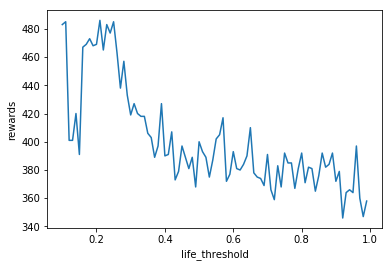

In [35]:
x = []
y = []
for b in np.arange(0.1,1.,.01):
    x.append(b)
    y.append(AG_L(n=10000,life_threshold=b, verbose=False))
plt.plot(x,y)
plt.xlabel('life_threshold')
plt.ylabel('rewards')
pass

In [71]:
import sys
import time

In [73]:
agl = []
ag = []
for i in range(1000):
    agl.append(AG_L(n=1000,verbose=False))
    ag.append(AG_L(n=1000, life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)

In [78]:
import seaborn as sns

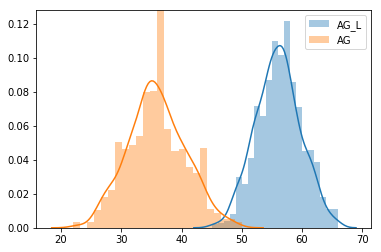

In [84]:
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

In [316]:
def ucb(x, i, c, records, lives):
    time = records[i]['timestamp']
    article = x[0]
    acc_reward, T = x[1]
    s, l = lives[article]
    if time > l:
        return 0
    return acc_reward/T + c*np.log(l-time+1) * np.sqrt(2*np.log(time-s) / T)
    
# offline simulation for AG_L
# fast version, consumes much less records
def UCB_L(n=1000000, c=1, m=25, verbose=True):
    # records should be long enough
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    global records
    global lives # dict of articles to their lifespans
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked']
        if displayed not in X.keys():
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    #i=50400
    while t<=n:
        while i<len(records):
            fake = False
            displayed = records[i]['displayed']
            clicked = records[i]['clicked']
            
            if displayed not in X.keys():
                fake = True
                estimation = sum(map(lambda x:x[0]/x[1], X.values())) / len(X)
                X[displayed] = np.array([estimation, 1])
                
            best = max(X.items(), key= lambda x:ucb(x, i, c, records, lives))
            
            if fake:
                X.pop(displayed)

            if displayed == best[0]:
                rewards += clicked
                X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
                break
            #print(displayed, best[0])
            i += 1
            
        if i%1000==0:
            print(t,i)
            
        t += 1
        i += 1
    if verbose:
        print('# X', len(X.keys()))
        print('# records', i)
    
    return rewards

In [317]:
UCB_L(n=10000,c=.01)

501 13000
1007 25000
2373 59000
4182 102000
7328 174000
7373 175000
7429 176000
8070 190000
8405 197000
9216 214000
9325 216000
9459 219000
# X 27
# records 230489


482

In [318]:
UCB_L(n=10000,c=.1)

547 13000
6254 151000
7399 175000
7774 183000
8655 201000
8951 207000
9009 208000
# X 27
# records 229403


377

In [319]:
UCB_L(n=10000,c=1)

1209 30000
1745 44000
2418 60000
2728 67000
2849 70000
4186 102000
6250 152000
7801 185000
# X 27
# records 230380


340

In [320]:
UCB_L(n=10000,c=10)

1767 44000
2837 69000
4455 106000
5122 122000
5166 123000
6363 151000
6891 162000
7018 165000
7887 183000
# X 27
# records 228742


324

In [321]:
UCB_L(n=10000,c=100)

2604 64000
2761 67000
3581 86000
5669 136000
6376 152000
6610 157000
6752 160000
7719 179000
8898 203000
# X 27
# records 227155


335

In [ ]:
x = []
y = []
for c in [.001, .01, .1, 1, 10, 100]:
    x.append(c)
    y.append(UCB_L(n=100, c=c, verbose=False))
plt.plot(x,y)

In [23]:
from collections import Counter

In [25]:
c=Counter()
i=0
while i<len(records):
    c[records[i]['clicked']] += 1
    i += 1
c

Counter({0: 1552903, 1: 54622})

In [28]:
c[1]/(c[0]+c[1])

0.03397894278471563